In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/experiments/cf`


In [2]:
using Revise
using CairoMakie
using Statistics
using LinearAlgebra

# Load the LES processing functions
includet("mixing_length.jl")

import ClimaCore.Quadratures.GaussQuadrature as GQ
import StaticArrays as SA
import Thermodynamics as TD
import ClimaAtmos.Parameters as CAP

[ Info: Precompiling AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6] 
┌ Info: Skipping precompilation due to precompilable error. Importing AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
┌ Info: Making AtmosConfig with config files: 
│    /home/jschmitt/experiments/cf/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
└    ClimaAtmos.jl/config/model_configs/prognostic_edmfx_bomex_pigroup_column.yml


In [19]:
sample_data = process_les_file(LES_DATA_PATH, params)

# Extract key variables at a single time and height point
t_idx = 250  # time index
z_idx = 31  # height index

qt_mean = sample_data["q_tot"][z_idx, t_idx]
theta_li_mean = sample_data["theta_li"][z_idx, t_idx]
qt_gradient = sample_data["qt_gradient"][z_idx, t_idx]
theta_gradient = sample_data["thetali_gradient"][z_idx, t_idx]
mix_len = sample_data["mix_len_no_z"][z_idx, t_idx]
# get the pressure 
p = CAP.R_d(params) .* 1 ./ ds_profiles["alpha_mean"][z_idx, t_idx] .* ds_profiles["temperature_mean"][z_idx, t_idx]

93953.80060322933

In [12]:
theta_gradient

0.0005898586544986984

In [22]:
diagnostic_coeff = CAP.diagnostic_covariance_coeff(params)

function covariance_from_grad(coeff, mixing_length, ∇Φ, ∇Ψ)
    return 2 * coeff * mixing_length^2 * dot(∇Φ, ∇Ψ)
end

# Compute covariances using ClimaAtmos method
q_variance = covariance_from_grad(diagnostic_coeff, mix_len, [qt_gradient], [qt_gradient])
theta_variance = covariance_from_grad(diagnostic_coeff, mix_len, [theta_gradient], [theta_gradient])
theta_q_covariance = covariance_from_grad(diagnostic_coeff, mix_len, [theta_gradient], [qt_gradient])

println("Raw covariances:")
println("q_variance = ", q_variance)
println("theta_variance = ", theta_variance) 
println("theta_q_covariance = ", theta_q_covariance)

# Apply ClimaAtmos-style safeguards (similar to quad_loop function)
FT = Float64
eps_q = eps(FT) * max(eps(FT), qt_mean)
eps_θ = eps(FT)

# Raw standard deviations
σ_q_raw = sqrt(max(q_variance, 0))
σ_θ_raw = sqrt(max(theta_variance, 0))

# Apply safeguards like ClimaAtmos does
# Note: In actual ClimaAtmos, σ_q is limited to prevent negative q_tot_hat
# For now, we'll use the raw values but add epsilon protection
σ_q = max(σ_q_raw, eps_q)
σ_θ = max(σ_θ_raw, eps_θ)

println("Standard deviations:")
println("σ_q = ", σ_q)
println("σ_θ = ", σ_θ)

# Numerically stable correlation calculation (like ClimaAtmos)
# _corr = theta_q_covariance / max(σ_q, eps_q)
# #correlation = max(min(_corr / max(σ_θ, eps_θ), 1.0), -1.0)
# correlation = clamp(_corr / max(σ_θ, eps_θ), -1.0, 1.0)
correlation = theta_q_covariance / (σ_q * σ_θ)
println("Correlation calculation:")
println("_corr = ", _corr)
println("final correlation = ", correlation)

# Check if we're hitting the bounds
if abs(correlation) >= 0.99
    println("WARNING: Correlation is hitting bounds! This suggests:")
    println("1. Covariances might be too large relative to variances")
    println("2. Check gradients and mixing length values")
    println("3. Consider if diagnostic_coeff is appropriate")
end

Raw covariances:
q_variance = 2.629347533996079e-9
theta_variance = 0.03658560885506321
theta_q_covariance = -9.807970249893989e-6
Standard deviations:
σ_q = 5.127716386459063e-5
σ_θ = 0.19127364913929784
Correlation calculation:
_corr = -0.19127364913929784
final correlation = -1.0
1. Covariances might be too large relative to variances
2. Check gradients and mixing length values
3. Consider if diagnostic_coeff is appropriate


In [10]:
diagnostic_coeff = CAP.diagnostic_covariance_coeff(params)

function covariance_from_grad(coeff, mixing_length, ∇Φ, ∇Ψ)
    return 2 * coeff * mixing_length^2 * dot(∇Φ, ∇Ψ)
end
# Compute covariances using ClimaAtmos method
q_variance = covariance_from_grad(diagnostic_coeff, mix_len, [qt_gradient], [qt_gradient])
theta_variance = covariance_from_grad(diagnostic_coeff, mix_len, [theta_gradient], [theta_gradient])
theta_q_covariance = covariance_from_grad(diagnostic_coeff, mix_len, [theta_gradient], [qt_gradient])

# Standard deviations
σ_q = sqrt(q_variance)
σ_θ = sqrt(theta_variance)

# Correlation coefficient (with Cauchy-Schwarz enforcement)
correlation = theta_q_covariance / (σ_q * σ_θ)
correlation = max(min(correlation, .99), -.99)  # Enforce |corr| ≤ 1


-0.99

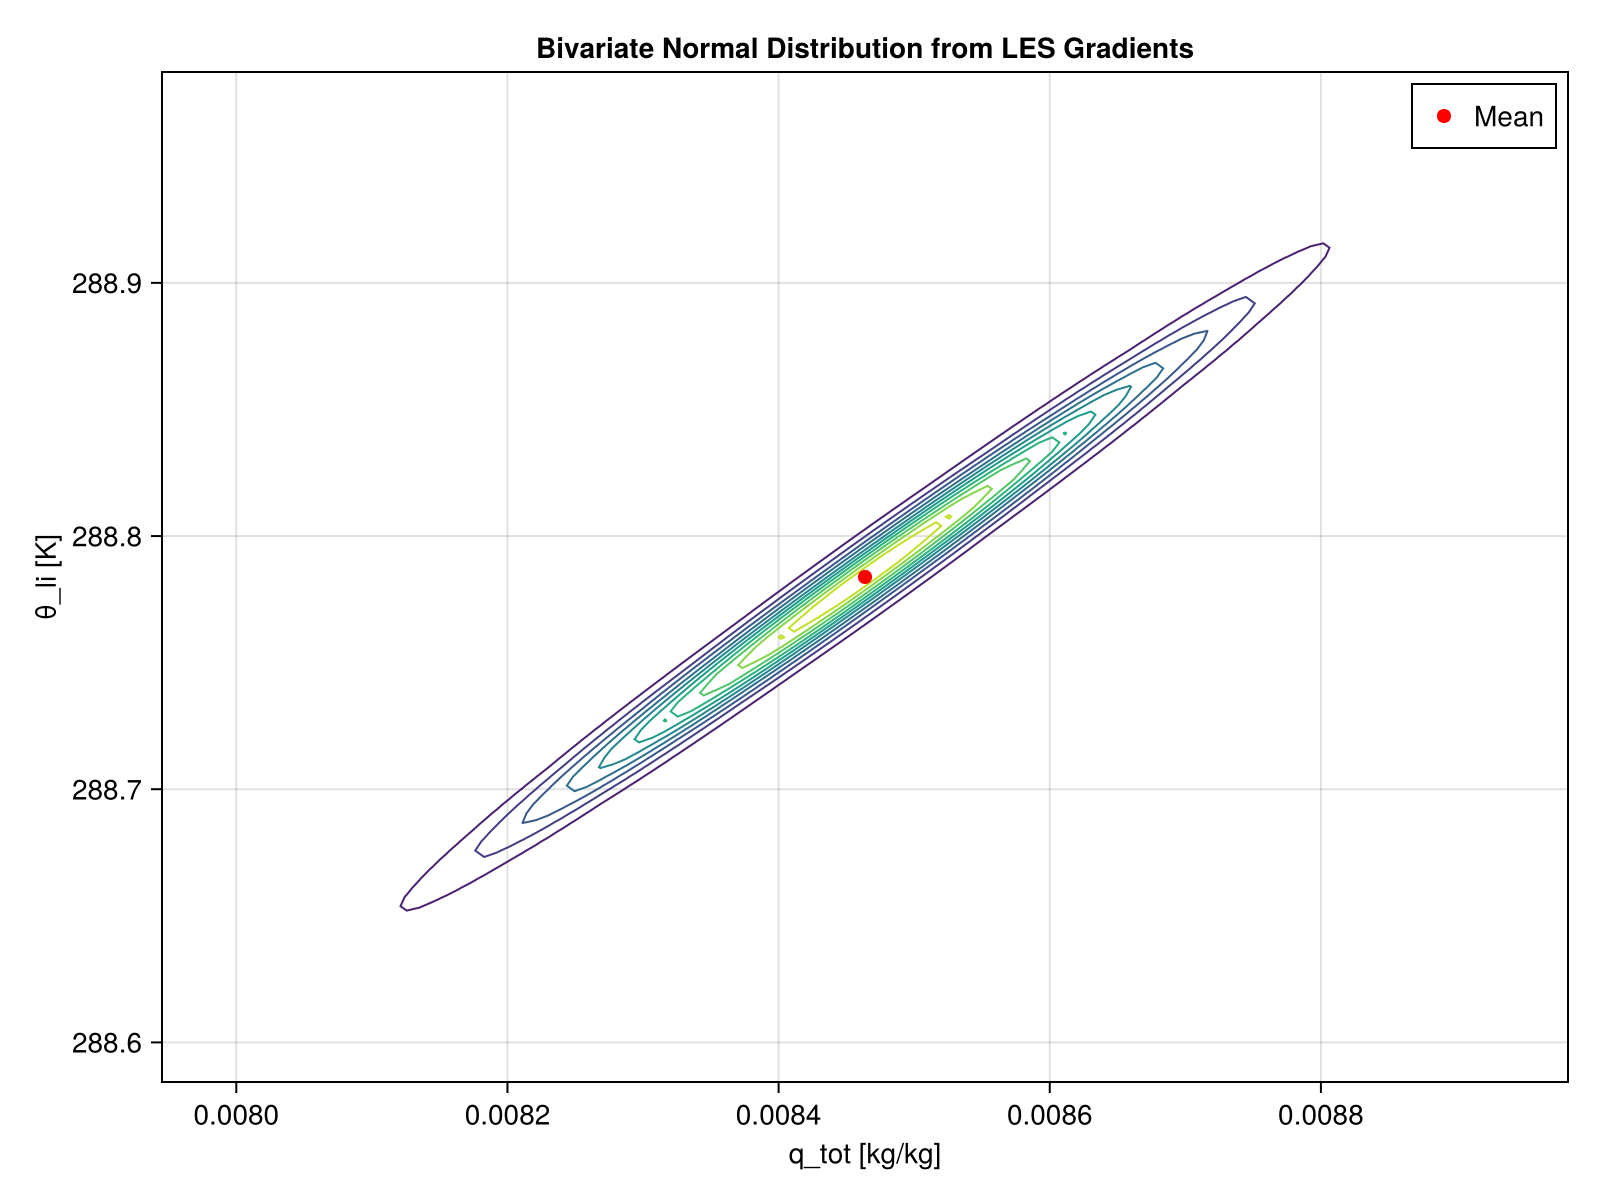

In [6]:
# Create a grid of points around the mean
q_range = range(qt_mean - 3*σ_q, qt_mean + 3*σ_q, length=100)
θ_range = range(theta_li_mean - 3*σ_θ, theta_li_mean + 3*σ_θ, length=100)

# Create the bivariate normal distribution
function bivariate_normal_pdf(q, θ, μ_q, μ_θ, σ_q, σ_θ, ρ)
    z1 = (q - μ_q) / σ_q
    z2 = (θ - μ_θ) / σ_θ
    
    exponent = -(z1^2 - 2*ρ*z1*z2 + z2^2) / (2*(1-ρ^2))
    normalization = 1 / (2*π*σ_q*σ_θ*sqrt(1-ρ^2))
    
    return normalization * exp(exponent)
end

# Compute PDF on grid
pdf_values = [bivariate_normal_pdf(q, θ, qt_mean, theta_li_mean, σ_q, σ_θ, correlation) 
              for θ in θ_range, q in q_range]
pdf_values
# Plot
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1], 
    xlabel="q_tot [kg/kg]", 
    ylabel="θ_li [K]",
    title="Bivariate Normal Distribution from LES Gradients"
)

# Contour plot
contour!(ax, q_range, θ_range, pdf_values', levels=10, colormap=:viridis)

# Mark the mean
scatter!(ax, [qt_mean], [theta_li_mean], color=:red, markersize=10, label="Mean")

# Add marginal distributions
# (Optional: plot 1σ, 2σ ellipses)

axislegend(ax)
fig

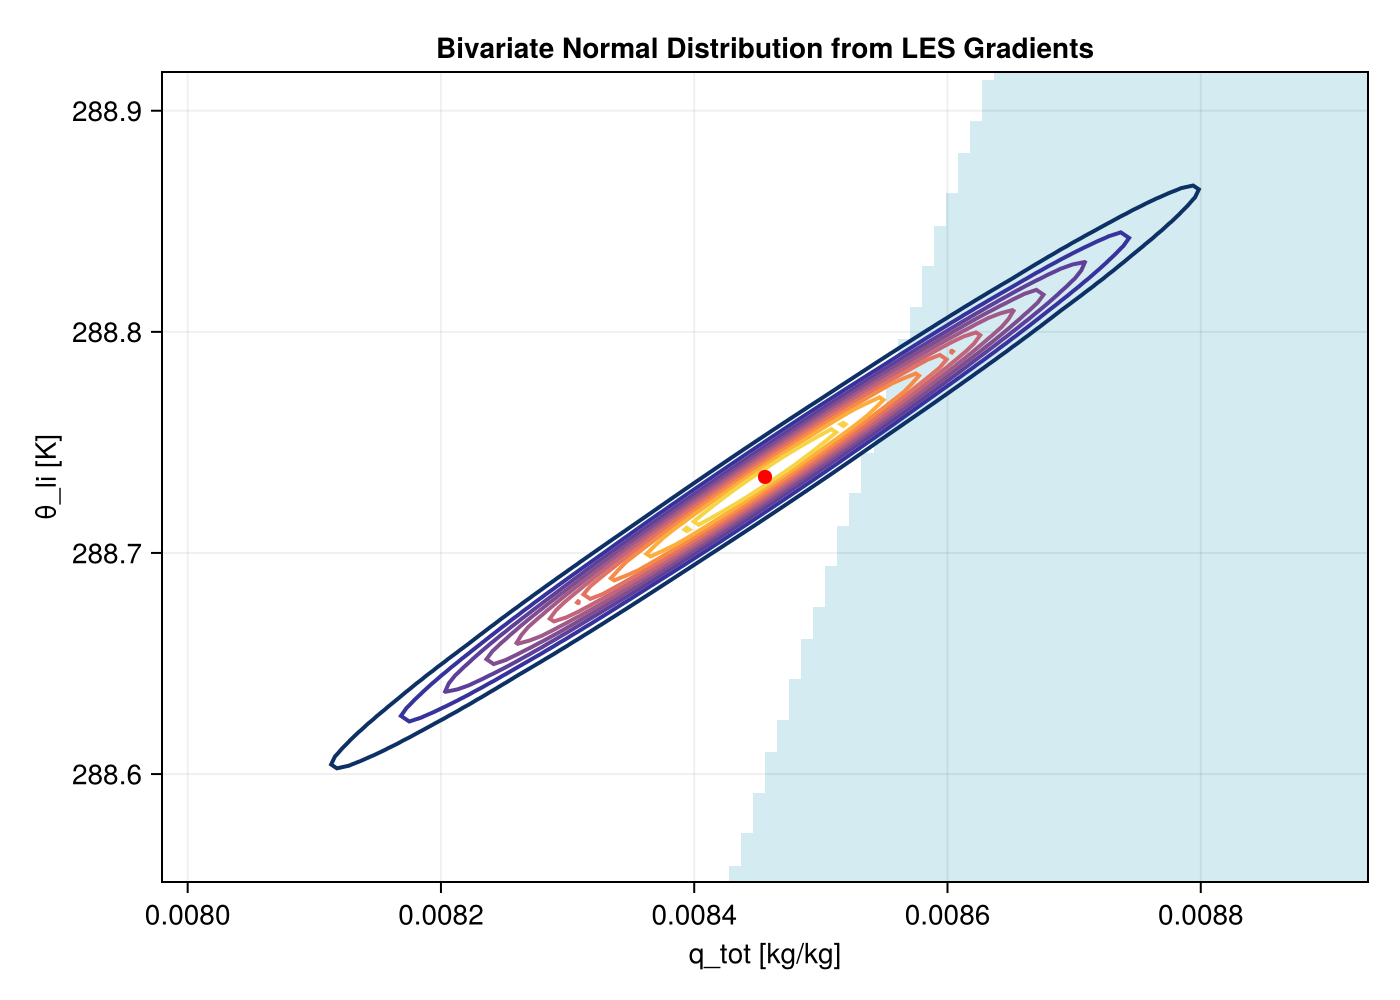

In [7]:
t_idx = 250  # time index
z_idx = 30  # height index

qt_mean = sample_data["q_tot"][z_idx, t_idx]
theta_li_mean = sample_data["theta_li"][z_idx, t_idx]
qt_gradient = sample_data["qt_gradient"][z_idx, t_idx]
theta_gradient = sample_data["thetali_gradient"][z_idx, t_idx]
mix_len = sample_data["mix_len_no_z"][z_idx, t_idx]
# get the pressure 
p = CAP.R_d(params) .* 1 ./ ds_profiles["alpha_mean"][z_idx, t_idx] .* ds_profiles["temperature_mean"][z_idx, t_idx]


q_range = range(qt_mean - 3*σ_q, qt_mean + 3*σ_q, length=100)
θ_range = range(theta_li_mean - 3*σ_θ, theta_li_mean + 3*σ_θ, length=100)

# compute whether or not the parcel is saturated 
thermo_params = CAP.thermodynamics_params(params)

Q, Θ = [x for x in Iterators.product(q_range, θ_range)] |> x -> (reshape(first.(x), 100, 100), reshape(last.(x), 100, 100))


# compute whether or not the points have condensate 
_ts = TD.PhaseEquil_pθq.(thermo_params, p, Θ, Q)
condensate_bool = TD.has_condensate.(thermo_params, _ts)


# visualize 
fig = Figure(size = (700, 500))
ax = Axis(fig[1, 1],
    xlabel = "q_tot [kg/kg]",
    ylabel = "θ_li [K]",
    title = "Bivariate Normal Distribution from LES Gradients"
)

# Subtle binary background for saturation (e.g., unsaturated vs saturated)
hm = heatmap!(ax, q_range, θ_range, condensate_bool;
    colormap = [:white, :lightblue], colorrange=(0,1), interpolate=false, alpha=0.5
)

# Contour overlay for bivariate PDF
contour!(ax, q_range, θ_range, pdf_values'; levels=10, colormap=:thermal, linewidth=2)

# Mark the mean
sc = scatter!(ax, [qt_mean], [theta_li_mean], color=:red, marker=:circle, markersize=10)

# Add a legend manually
# Legend(fig[1, 2], [hm, sc], ["Saturated region", "Mean"], tellwidth=false)

fig


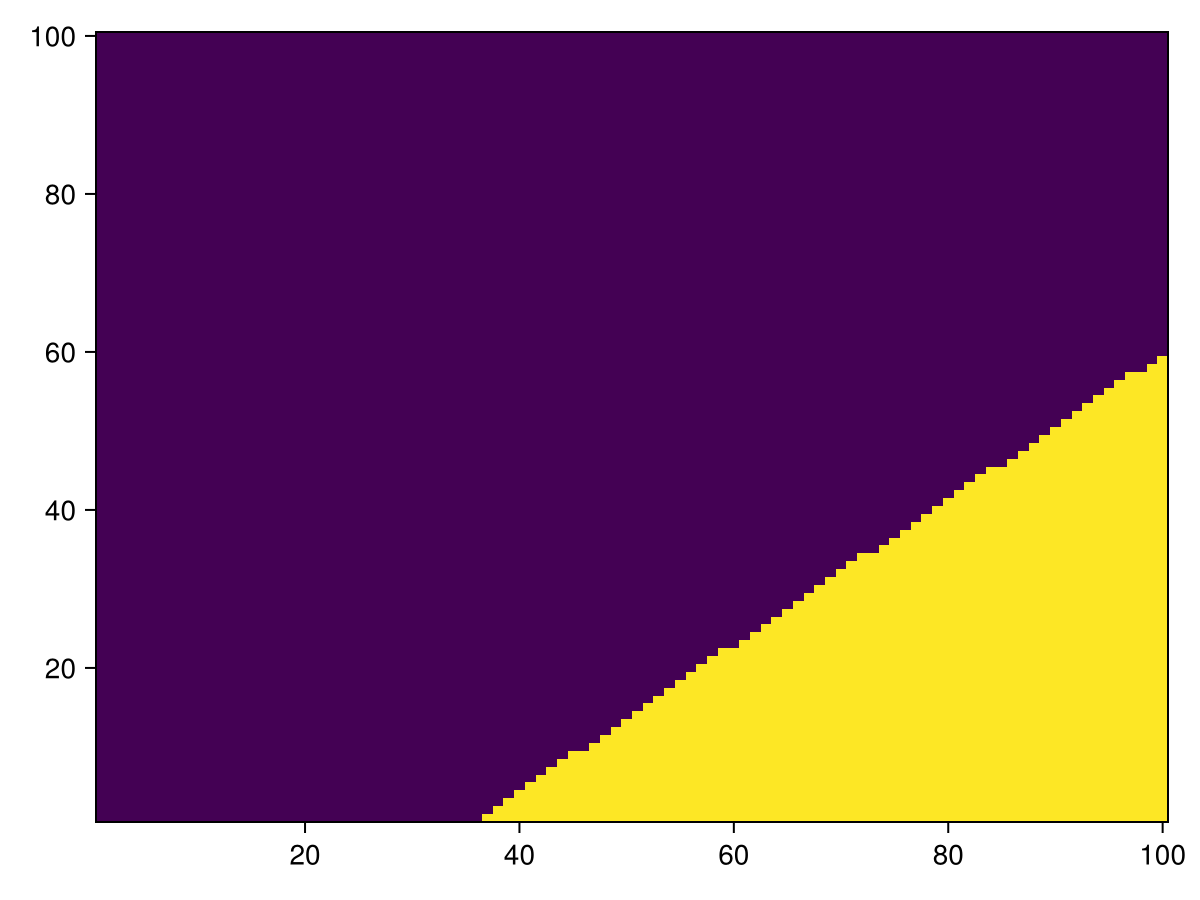

In [48]:
heatmap(condensate_bool)